In [1]:
!pip install collections
!pip install geoutils

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
  Using cached geoutils-0.1.0-py3-none-any.whl (84 kB)


In [2]:
import pyproj
from pyproj import Proj, transform
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from scipy import interpolate
from datetime import date, datetime, timedelta
from sklearn import linear_model
#from collections import Iterable 
import rasterio as rio
from datetime import date, datetime, timedelta
import glob as glob
from pyproj import Transformer
import geoutils as gu

In [3]:
# Load bed, dem, sat image, and velocities
proj_alaska = 3338
bed = gu.Raster('hubbard_bilinear_elev_3413.tif').reproject(crs=proj_alaska)
dem = gu.Raster('ifsar_hubbardDEM.tif').reproject(bed, nodata = np.nan)
sat_image = gu.Raster('S1A_IW_20230823T025520_DVP_RTC30_G_gdufem_1CFD_VV.tif').reproject(bed, nodata = np.nan)
vels_ds = xr.open_dataset('hubbard_inversion_2015-10-01_2023-01-01.nc')

In [15]:
from ipyleaflet import Map, Marker, basemaps, AwesomeIcon
from ipywidgets import HTML
from IPython.display import display
import ipyleaflet as ipyl


# Create a rotating array of colors to differenciate the markers
colors = ['red', 'green', 'blue', 'purple', 'gray', 'orange', 'beige']


# Create an empty list to store the markers
markers = []
temp_list = []
counter = 0

# Create a map
m = ipyl.Map(basemap=basemaps.Esri.WorldImagery, center=(0, 0), zoom=2)
m.scroll_wheel_zoom = True

# Function to handle click events
def handle_click(**kwargs):
    global counter
    global temp_list
    
    if kwargs.get('type') == 'click':
        
        icon = AwesomeIcon(name='fa-cog', marker_color = colors[counter])
        coords = kwargs.get('coordinates')
        marker = Marker(location=coords, icon=icon, draggable = True)
        temp_list.append(marker)
        
        if len(temp_list) == 2:
            markers.append(temp_list)     
            temp_list = []
            counter += 1
        m.add_layer(marker)
        
        display(HTML("Point added at coordinates: {}".format(coords)))

# Function to handle drag events
def handle_drag(event, marker):
    new_coords = marker.location
    index = markers.index(marker)
    points[index] = new_coords
    print("Marker {} dragged to coordinates: {}".format(index, new_coords))

# Add click event handler to the map
m.on_interaction(handle_click)

# Bind drag event handler to each marker
for marker in markers:
    marker.on_drag(handle_drag)

# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [16]:
# Choose amount of points you want on your transect
num_points = 20

In [17]:
points = [[(marker.location[0], marker.location[1]) for marker in points] for points in markers]


In [18]:
import pyproj
import numpy as np
import pandas as pd


def interpolate_points(x1, y1, x2, y2, num_points):
    # Generate num_points equally spaced points between (x1, y1) and (x2, y2)
    x_values = np.linspace(x1, x2, num_points)
    y_values = np.linspace(y1, y2, num_points)
    return list(zip(x_values, y_values))

def get_equally_spaced_points(points, num_points):
    interpolated_points = []
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        interpolated_points.extend(interpolate_points(x1, y1, x2, y2, num_points))
    return interpolated_points


# Function to find index of closest value
def find_closest_index(arr, value):
    return np.abs(arr - value).argmin()


def get_indices_fluxgate(ds, sat_image, points, num_points, color):
    # Define the source and target coordinate reference systems (CRS)
    src_crs = pyproj.CRS('EPSG:4326')
    target_crs = ds.crs

    # Define the transformer to transform coordinates from source CRS to target CRS
    transformer = pyproj.transformer.Transformer.from_crs(src_crs, target_crs, always_xy = True)
    
    equally_spaced_points = get_equally_spaced_points(points, num_points)

    # Transform the coordinates to the target CRS
    transformed_points = [transformer.transform(p[1], p[0]) for p in equally_spaced_points]

    # Extract x and y coordinates from the transformed points
    transformed_x = [p[0] for p in transformed_points]
    transformed_y = [p[1] for p in transformed_points]

    # Extract x, y coordinates of the tif
    dsx = ds.coords()[0][0,:]
    dsy = ds.coords()[1][:,0]

    # Find indices for x_long closest to X
    indices_x = [find_closest_index(dsx, val) for val in transformed_x]

    # Find indices for y_long closest to Y
    indices_y = [find_closest_index(dsy, val) for val in transformed_y]
    
    # Indices array
    crossed_points = [(x,y) for x,y in zip(indices_x, indices_y)]
    
    # Create bed array with NaNs
    test = bed.data.data.copy()
    test[test==np.nanmin(test)]=np.nan
 

    # Generate figure showing points generated
    plt.figure()
    plt.imshow(sat_image.data.data)
    plt.imshow(test, cmap = 'jet')
    for x,y in zip(indices_x, indices_y):
        plt.scatter(x,y, color = color)
        
    return crossed_points, transformed_points



def Fluxgate(th_points, tr, deltax, deltay, k = 1):

    flux = np.nansum(th_points * k * (tr.vx.values * deltay - tr.vy.values * deltax),axis=1)
    fluxpt = np.sum(th_points * k * (tr.vx.values * deltay - tr.vy.values * deltax),axis=0)
    
    # Calculate flux for the dataset
    return np.abs(flux), np.abs(th_points), np.abs(fluxpt)




def Flux_Calculate(points, vels_ds, num_points):
    
    flux_list = []
    fluxpt_list = []
    tr_list = []
    dist_list = []
    thickness_list = []
    vels_list = []
    
    for p in range(len(points)):

        # Get the indices of the points in the datasets
        pts, coords_pts = get_indices_fluxgate(bed, sat_image, points[p], num_points, colors[p])
        x_bed = bed.coords()[0][0,:]
        y_bed = bed.coords()[1][:,0]

        source_proj = bed.crs  # Assuming the coordinates are in EPSG:4326 (WGS84)
        target_proj = pyproj.crs.CRS(vels_ds.attrs['projection'])  # Assuming vels.attrs['projection'] contains the target EPSG code

        # Define the transformer to transform coordinates from source CRS to target CRS
        transformer = pyproj.transformer.Transformer.from_crs(source_proj, target_proj, always_xy = True)

        # Transform the coordinates to the target CRS
        reprojected_coords = [transformer.transform(p[0], p[1]) for p in coords_pts]

        # Calculate thickness of ice
        thickness = np.array([dem.data.data[point[1],point[0]] for point in pts]) - np.array([bed.data.data[point[1],point[0]] for point in pts])
        thickness[thickness==np.max(thickness)]=np.nan
        thickness = (thickness[1:] + thickness[:-1]) / 2

        # Save pts as dataframe
        pts = pd.DataFrame(reprojected_coords, columns=['x', 'y'])

        deltax = np.diff(pts.x.values)
        deltay = np.diff(pts.y.values)
        xmid = pts.x.values[0:-1] + deltax*0.5
        ymid = pts.y.values[0:-1] + deltay*0.5

        # Update the coordinates at which we calculate flux
        pts = pd.DataFrame({'x':xmid, 'y':ymid})

        # From the velocity dataset, extract values of points at the fluxgate
        tr = vels_ds.sel(y=xr.DataArray(pts.y.values, dims='z'), 
                            x=xr.DataArray(pts.x.values, dims='z'), 
                            method='nearest'
                            ).interpolate_na(dim="z", method="nearest").interpolate_na(dim='time', method='cubic')


        # Calculate flux
        flux, thpoints, fluxpt = Fluxgate(thickness, tr, deltax, deltay)

        # Create a date vector for plotting
        drange = tr.time.values
        dist = [np.sqrt((pts.x[i]-pts.x[i-1])**2+(pts.y[i]-pts.y[i-1])**2) for i in range(1,len(pts))]
        dist = np.array(np.hstack((np.array([0]), np.cumsum(dist))))

        # Sum vels
        vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)
        
        # Save in lists
        dist_list.append(dist)
        flux_list.append(flux)
        fluxpt_list.append(fluxpt)
        tr_list.append(tr)
        thickness_list.append(thickness)
        vels_list.append(vels)


    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        plt.plot(dist_list[p], (fluxpt_list[p]/tr_list[p].time.shape[0])/1e9, label = 'Average flux along transect', color = colors[p])
    plt.ylabel(f"Flux [km3/{int((tr.time[1] - tr.time[0])/ np.timedelta64(1, 'D'))} days (opaque curves)]")
    plt.xlabel('Distance along flux')
    plt.ylim(bottom=0)
    #plt.legend(loc='upper left')

    # Adding ice thickness plot on secondary y-axis
    plt.twinx()
    for p in range(len(points)):
        plt.plot(dist_list[p], thickness_list[p], color=colors[p], alpha = 0.5, label='Ice thickness')
    plt.ylabel('Ice thickness (low-opacity curves)')
    plt.title('Flux and Ice Thickness along Distance [m]')

    # Adding legends
    #plt.legend(loc='lower left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()


    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        plt.plot(tr_list[p].time, flux_list[p]/1e9, label = 'Transect flux in time', color = colors[p])
    plt.ylabel(f"Flux [km3/year]")
    plt.xlabel('Time')
    plt.ylim(bottom=0)


    # Adding legends
    plt.legend(loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.title('Total flux along transect in time')
    plt.show()
    
    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        plt.plot(tr_list[p].time, vels_list[p], label = 'Average velocity transect in time', color = colors[p])
    plt.ylabel(f"Velocity [m/yr]")
    plt.xlabel('Time')
    plt.ylim(bottom=0)


    # Adding legends
    plt.legend(loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.title('Average velocity of transect in time')
    plt.show()


    return flux, fluxpt, vels, dist

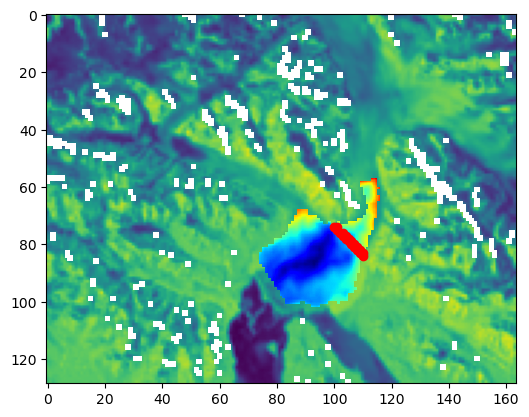

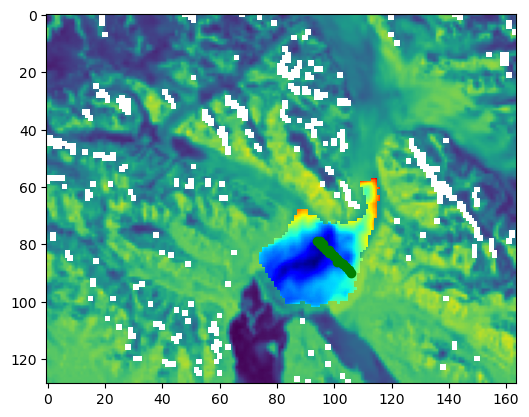

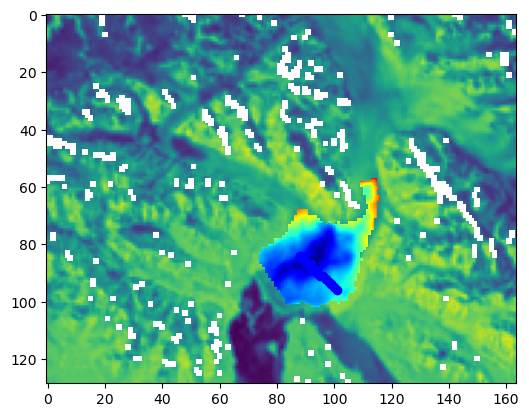

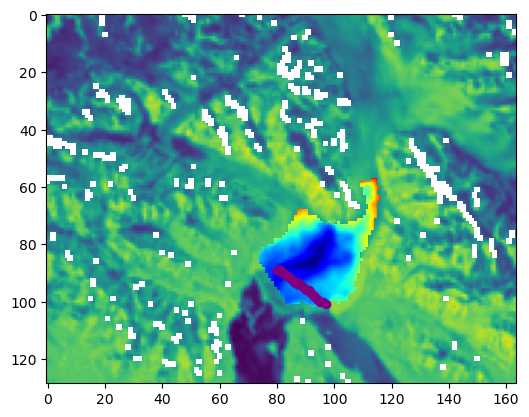

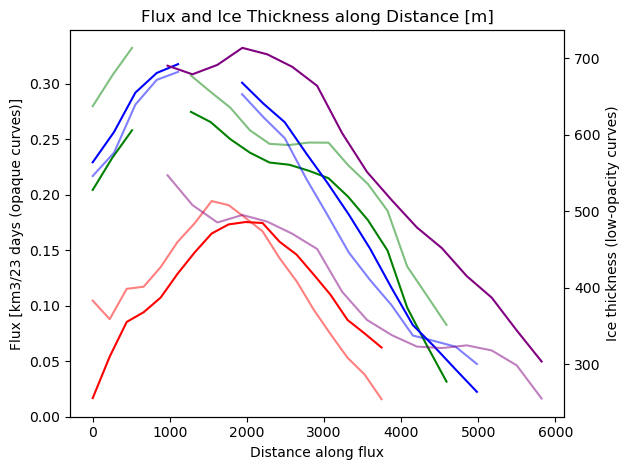

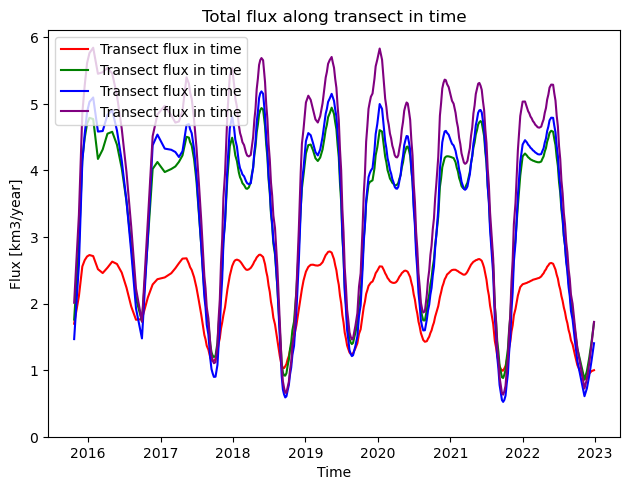

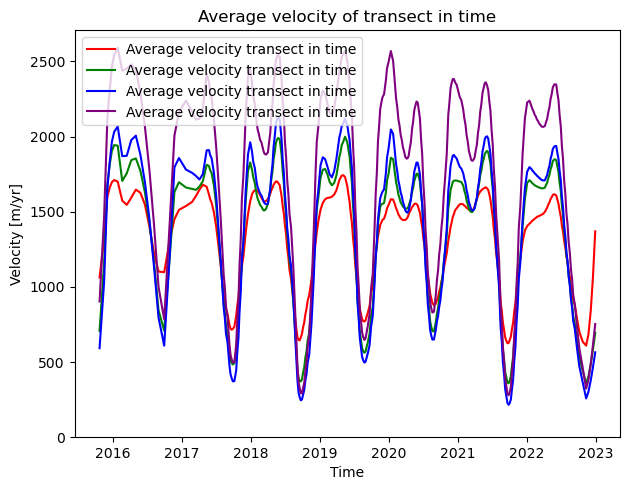

In [19]:
flux, fluxpt, vels, dist = Flux_Calculate(points, vels_ds, 20)